In [1]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
from wombat.engine import ml_model
from wombat.engine import one_hot_funcs
from wombat.engine.one_hot_funcs import create_one_hot_row_brand_keyword
from wombat.models import Item, Brand
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
from sklearn.metrics import mean_absolute_error
from wombat.engine import one_hot_funcs
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)

# suppress pandas warning about operations on copies of dfs
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [9]:
df = ml_model.canonical_df
#df = df.loc[(df['item_type'] == 'dresses') & (df['cost'] < 1000)]
df = df.loc[(df['cost'] < 1000)]
df = df.loc[(df['rent_per_week'] < 1000)]

# split data into train and test group
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# copy of train before we delete the 'rent_per_week' and 'title' field. We want title 
# we will need these things before we make dummy variables
df_full_training = df[df['is_train']==True]
df_full_test = df[df['is_train']==False]

# get one-hot columns for item_types
dummified_items = pd.get_dummies(df['item_type'])
df = pd.concat([df, dummified_items], axis = 1)
df = df.drop(['item_type'], axis = 1)

## Dummify brands

This is if you want to one hot encode the brands yourself

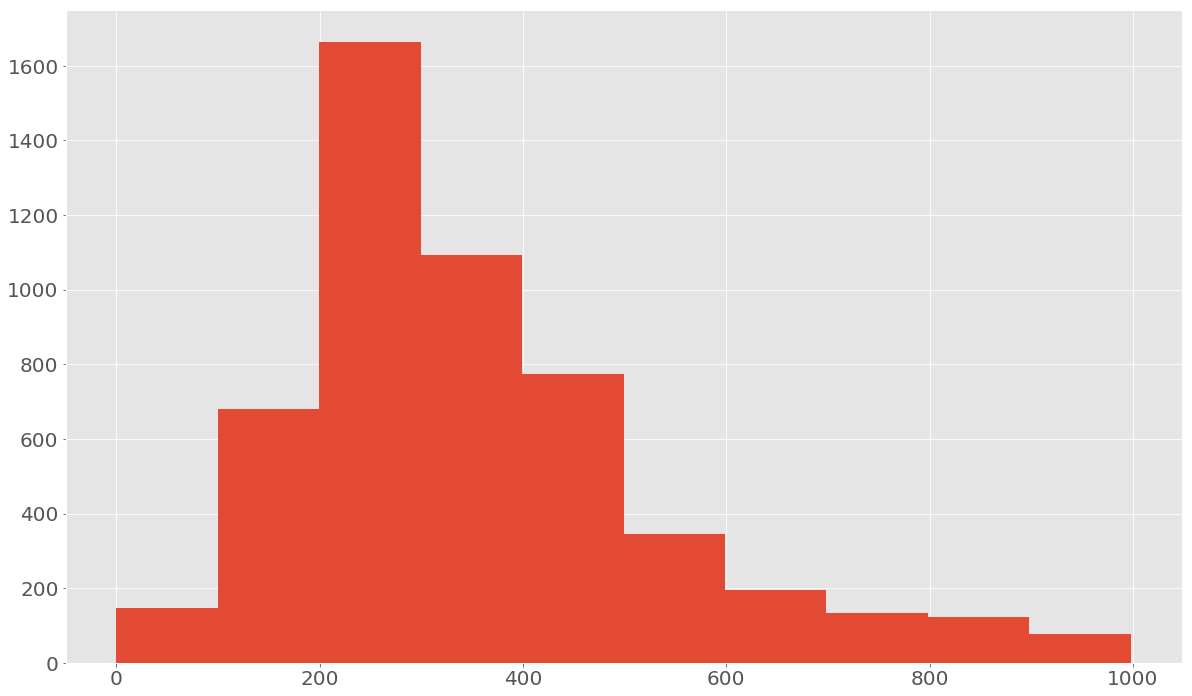

In [49]:
df['cost'].hist()

In [10]:
df_brands = pd.read_sql_query('SELECT * FROM "brands"', con=engine)

brands = df_brands['name'].values
keywords = df_brands['keywords'].values

# unknown brands are brands we pull from the large df. 
# They may be mislabeled so we need to sort them and one-hot them to a known list of brands
unknown_brands = df['brand'].values

one_hotted_brands = []

for unknown_brand in unknown_brands:
    one_hotted_brands.append(create_one_hot_row_brand_keyword(unknown_brand, keywords))
    
    
df_brands = pd.DataFrame(one_hotted_brands, columns = brands, index = df.index.values)
df = pd.concat([df, df_brands], axis = 1)

df = df.drop(['brand'], axis = 1)
df

,title,cost,rent_per_week,description,is_train,accessories,bags,bottoms,dresses,outerwear,pants,rompers,shirts,shoes,skirts,tops,Tadashi Shoji,other brand,Alice + Olivia,For Love & Lemons,Adrianna Papell,Parker,Nicole Miller,Dress the Population,Lovers + Friends,Halston Heritage,Chanel,Elizabeth and James,Herve Leger,Calvin Klein,Trina Turk,Mara Hoffman,Self-Portrait,Milly,Suno,DVF,Ted Baker,Tibi,Badgley Mischka,Black Halo,Aidan Mattox,Helmut Lang,Haute Hippie,French Connection,Rebecca Taylor,Rachel Zoe,Yves Saint Laurent,Laundry by Shelli Segal,Christian Louboutin,Shoshanna,...,Banana Republic,Gryphon,Hayley Paige Occasions,Nicole Bakti,Narciso Rodriguez,Lanvin,Yoana Baraschi,Badgley Mischka,Alaia,Kay Unger,Style Lend,Missoni,Mynt,cooper & ella,Philip Lim,Coach,Balmain,"Young, Fabulous & Broke",Giuseppe Zanotti,Reformation,Carmella,Via Spiga,Escada,Hugo Boss,Thakoon,Maison Scotch,Prabal Gurung,Ceremony by Joanna August,Frame Denim,Jonathan Saunders,Iro,Giorgio Armani,Marni,Amanda Uprichard,Dolce & Gabbana,Maje,Jenny Yoo,Jason Wu,Stone Cold Fox,French Connection,La Femme,Rory Beca,Max Mara,Yumi Kim,IGIGI,Terani Couture,Salvatore Ferragamo,Maggy London,Katya Lee Designs,BCBG
0,Ava guipure lace mini dress,520.0,99.0,Self-Portrait's 'Ava' mini dress is perfect fo...,True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Lurex Dress,695.0,69.0,"Tibi Detailed with metallic gold fil coupe, th...",False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The Diamond Back Dress,239.0,33.9,A beautiful navy blue lace dress with a diamon...,True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Sparkling Cocktail dress,350.0,45.5,Flattering scoop neck bodycon dress with glist...,True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Long V-Neck Beaded Gown Gunmetal,349.0,49.0,This floor sweeping gown from Adrianna Papell ...,True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Lace Backout Gown,798.0,89.0,This dress is perfect for your next formal occ...,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,pink kathlin argiro cocktail dress,400.0,50.0,Beautiful Kathlin Argiro dress! 98%polyster pi...,True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Valentina Mini Dress,292.0,45.0,"Inspired from travels to Europe, this mini was...",False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,The Jetset Diaries Vera Maxi Dress,329.0,45.0,Maxi silhouette.\nSemi-sheer overlay dress boa...,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,The Jetset Diaries Zulu Maxi Dress,229.0,35.0,Maxi silhouette features a crisscross detail a...,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0

In [4]:
print(len(df.columns))
df

227


,item_type,title,cost,rent_per_week,description,is_train,Tadashi Shoji,other brand,Alice + Olivia,For Love & Lemons,Adrianna Papell,Parker,Nicole Miller,Dress the Population,Lovers + Friends,Halston Heritage,Chanel,Elizabeth and James,Herve Leger,Calvin Klein,Trina Turk,Mara Hoffman,Self-Portrait,Milly,Suno,DVF,Ted Baker,Tibi,Badgley Mischka,Black Halo,Aidan Mattox,Helmut Lang,Haute Hippie,French Connection,Rebecca Taylor,Rachel Zoe,Yves Saint Laurent,Laundry by Shelli Segal,Christian Louboutin,Shoshanna,Kate Spade,The Jetset Diaries,Clover Canyon,Free People,Theory,Kristi Vosbeck,Keepsake the Label,Gucci,Nanette Lepore,Donna Morgan,...,Banana Republic,Gryphon,Hayley Paige Occasions,Nicole Bakti,Narciso Rodriguez,Lanvin,Yoana Baraschi,Badgley Mischka,Alaia,Kay Unger,Style Lend,Missoni,Mynt,cooper & ella,Philip Lim,Coach,Balmain,"Young, Fabulous & Broke",Giuseppe Zanotti,Reformation,Carmella,Via Spiga,Escada,Hugo Boss,Thakoon,Maison Scotch,Prabal Gurung,Ceremony by Joanna August,Frame Denim,Jonathan Saunders,Iro,Giorgio Armani,Marni,Amanda Uprichard,Dolce & Gabbana,Maje,Jenny Yoo,Jason Wu,Stone Cold Fox,French Connection,La Femme,Rory Beca,Max Mara,Yumi Kim,IGIGI,Terani Couture,Salvatore Ferragamo,Maggy London,Katya Lee Designs,BCBG
0,dresses,Ava guipure lace mini dress,520.0,99.0,Self-Portrait's 'Ava' mini dress is perfect fo...,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,dresses,Lurex Dress,695.0,69.0,"Tibi Detailed with metallic gold fil coupe, th...",True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,dresses,The Diamond Back Dress,239.0,33.9,A beautiful navy blue lace dress with a diamon...,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,dresses,Sparkling Cocktail dress,350.0,45.5,Flattering scoop neck bodycon dress with glist...,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,dresses,Long V-Neck Beaded Gown Gunmetal,349.0,49.0,This floor sweeping gown from Adrianna Papell ...,True,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,dresses,Lace Backout Gown,798.0,89.0,This dress is perfect for your next formal occ...,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,dresses,pink kathlin argiro cocktail dress,400.0,50.0,Beautiful Kathlin Argiro dress! 98%polyster pi...,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,dresses,Valentina Mini Dress,292.0,45.0,"Inspired from travels to Europe, this mini was...",True,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,dresses,The Jetset Diaries Vera Maxi Dress,329.0,45.0,Maxi silhouette.\nSemi-sheer overlay dress boa...,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,dresses,The Jetset Diaries Zulu Maxi Dress,229.0,35.0,Maxi silhouette features a crisscross detail

In [11]:
# get list of adjective features form database
features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]

#tokenized_titles = []
#for title in df['title']:
#    parse_title.create_one_hot_row_adj(title, features_adj)
#    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
#df_adj = pd.DataFrame(tokenized_titles, columns = features_adj, index = df.index.values)

tokenized_titles = []
for text_array in df[['title', 'description']].values:
    try:
        text = ' '.join(text_array)
    except TypeError:
        text = text_array[0]
    tokenized_titles.append(one_hot_funcs.create_one_hot_row_adj(text, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj, index = df.index.values)
df_w_adj = pd.concat([df, df_adj], axis = 1)

In [12]:
final_df = df_w_adj
features = final_df.columns.drop(['rent_per_week', 'title', 'is_train', 'description']) # just column names
train, test = final_df[final_df['is_train']==True], final_df[final_df['is_train']==False]
final_df[features]

,cost,accessories,bags,bottoms,dresses,outerwear,pants,rompers,shirts,shoes,skirts,tops,Tadashi Shoji,other brand,Alice + Olivia,For Love & Lemons,Adrianna Papell,Parker,Nicole Miller,Dress the Population,Lovers + Friends,Halston Heritage,Chanel,Elizabeth and James,Herve Leger,Calvin Klein,Trina Turk,Mara Hoffman,Self-Portrait,Milly,Suno,DVF,Ted Baker,Tibi,Badgley Mischka,Black Halo,Aidan Mattox,Helmut Lang,Haute Hippie,French Connection,Rebecca Taylor,Rachel Zoe,Yves Saint Laurent,Laundry by Shelli Segal,Christian Louboutin,Shoshanna,Kate Spade,The Jetset Diaries,Clover Canyon,Free People,...,sundress,matador,tulle,print,strapless,red,purple,casual,corded,sheath,tingle,floral,reformation,bordeaux,ronny,marble,scuba,premium,bardot,prairie,satin-crepe,winslow,turquoise,assymetrical,formal,metallic,elastic,belt,classic,clutch,bronze,wedges,cutout,snakeskin,floor,plunging,girly,patent,wood,suede,gala,runway,ball,costume,iconic,cavier,peacock,florence,mermaid,jersey
0,520.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,695.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,239.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,350.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,349.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,798.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,400.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,292.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,329.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,229.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
reg = RandomForestRegressor(n_jobs=2, n_estimators=10)

reg.fit(train[features], train['rent_per_week'].apply(np.log))
predicted = np.exp(reg.predict(test[features]))

X_sample = pd.Series(0, index = train[features].columns)
model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
model_path = os.path.join(model_dir, 'rfr_v0.4_w_adj_prices_better_brands.pkl')
#joblib.dump([X_sample, reg], model_path)
#call this with: clf = joblib.load('huber_v0.1.pkl')
#rfr_predicted
#stopping_value = np.minimum(np.maximum(test['rent_per_week'].values), np.maximum(rfr_predicted))

Slope of regression line for obs v pred:  [ 0.71145009]
mean_absolute_error: 7.363542724725017
R^2:  0.5965270381233023
Length of df_full_test: 1301
501


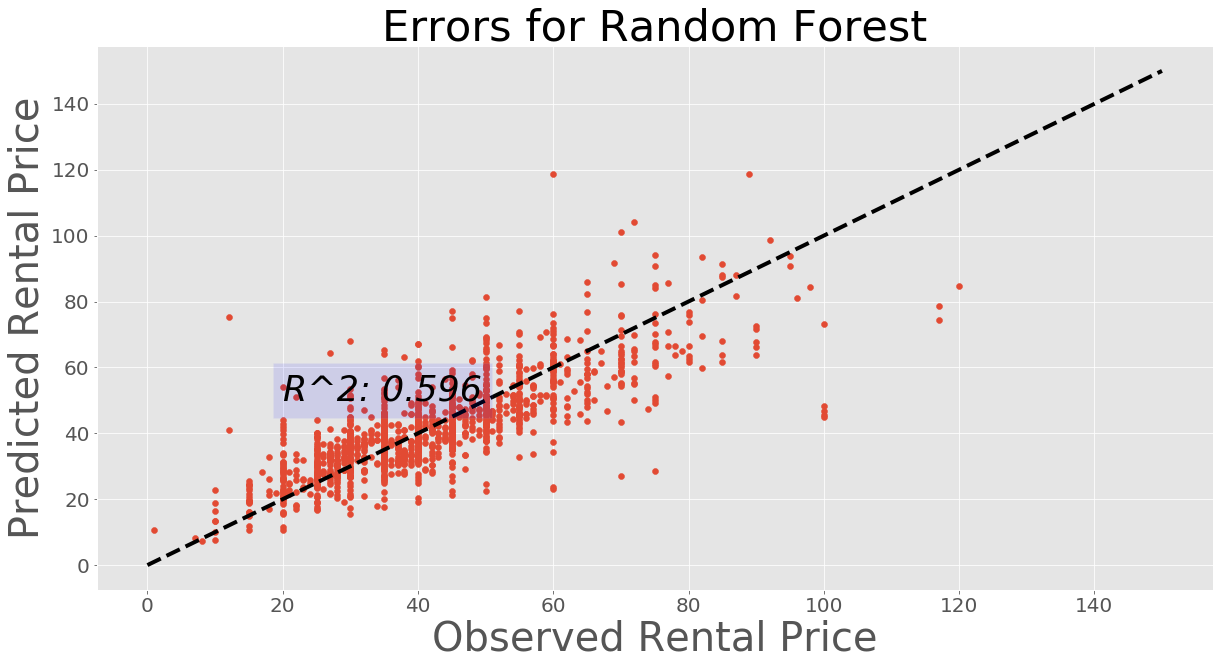

In [26]:
import matplotlib
from sklearn.metrics import r2_score

matplotlib.rcParams.update({'font.size': 30})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Create linear regression object for predicted vs measured
error_reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(predicted)

# Train the model using the training sets
error_reg.fit(x, y)

r2 = r2_score(test['rent_per_week'], predicted)

# The coefficients
print('Slope of regression line for obs v pred: ', error_reg.coef_)
print("mean_absolute_error: {}".format(mean_absolute_error(test['rent_per_week'], predicted)))
print("R^2:  {}".format(r2))
      
# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = predicted)
stopping_value = 150
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4, color="black")
ax.set_title('Errors for Random Forest')
ax.set_xlabel('Observed Rental Price', fontsize=40)
ax.set_ylabel('Predicted Rental Price', fontsize=40)
#ax.plot(x, error_reg.predict(x), 'k--', color='black', linewidth=3)

before_dec, after_dec = str(r2).split('.')
r2_str = float('.'.join((before_dec, after_dec[0:3])))
ax.text(0, 30, 'R^2: {}'.format(r2_str), style='italic', fontsize=35,
bbox={'facecolor':'blue', 'alpha':0.1, 'pad':10})

x = test['rent_per_week']
df_full_test['predicted_rent'] = predicted
#df_full_test['error'] = df_full_test[['rent_per_week', 'predicted_rent']].subtract(axis=1)
df_full_test['error'] = df_full_test['rent_per_week'] - df_full_test['predicted_rent']
df_full_test['abs_error'] = np.abs(df_full_test['rent_per_week'] - df_full_test['predicted_rent'])
print("Length of df_full_test: {}".format(len(df_full_test)))
#df_full_test['error'] = df_full_test['error'].abs()

# calculate number of items within a certain range
d_errors = df_full_test
num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 10)]
print(len(num_low_errors))

In [63]:
from sklearn.model_selection import cross_val_score
reg = RandomForestRegressor(n_jobs=2, n_estimators=10)
final_df = df_w_adj
y_values = final_df['rent_per_week']
features = final_df.columns.drop(['rent_per_week', 'title', 'is_train', 'description']) # just column names
#train, test = final_df[final_df['is_train']==True], final_df[final_df['is_train']==False]

#scores = cross_val_score(reg, iris.data, iris.target, cv=5)
#scores       
data = final_df[features]
scores = cross_val_score(reg, data.as_matrix(), y_values, cv=5)
scores

array([ 0.17237091, -1.65673078,  0.16243292,  0.48851941,  0.29881523])

In [64]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.11 (+/- 1.57)


In [21]:
brands_query = "SELECT * FROM brands;"
brands = [b[1] for b in engine.execute(brands_query).fetchall()]
keywords = [b[2] for b in engine.execute(brands_query).fetchall()]
brands
#keywords
#create_one_hot_row_brand_keyword(unknown_brand, keywords)

['Tadashi Shoji',
 'other brand',
 'Alice + Olivia',
 'For Love & Lemons',
 'Adrianna Papell',
 'Parker',
 'Nicole Miller',
 'Dress the Population',
 'Lovers + Friends',
 'Halston Heritage',
 'Chanel',
 'Elizabeth and James',
 'Herve Leger',
 'Calvin Klein',
 'Trina Turk',
 'Mara Hoffman',
 'Self-Portrait',
 'Milly',
 'Suno',
 'DVF',
 'Ted Baker',
 'Tibi',
 'Badgley Mischka',
 'Black Halo',
 'Aidan Mattox',
 'Helmut Lang',
 'Haute Hippie',
 'French Connection',
 'Rebecca Taylor',
 'Rachel Zoe',
 'Yves Saint Laurent',
 'Laundry by Shelli Segal',
 'Christian Louboutin',
 'Shoshanna',
 'Kate Spade',
 'The Jetset Diaries',
 'Clover Canyon',
 'Free People',
 'Theory',
 'Kristi Vosbeck',
 'Keepsake the Label',
 'Gucci',
 'Nanette Lepore',
 'Donna Morgan',
 'Three Floor',
 'Zimmermann',
 'Jay Godfrey',
 'Bebe',
 'Eliza J',
 'Topshop',
 'Vera Wang',
 'Alexander Wang',
 'ABS',
 'Rag & Bone',
 'A.L.C.',
 'Reformation',
 'Missoni',
 'Robert Rodriguez',
 'Needle & Thread',
 'Xscape',
 'Tracy Reese

In [115]:
brand = 'Tibi'
item_type = "dresses"
title = 'Lurex Dress'
est_price = 10

X_sample['cost'] = 10
X_sample[brand] = 1
X_sample[item_type] = 1
#X_sample.loc[X_sample['']]
adjectives_query = "SELECT * FROM item_adjectives;"
adjectives = [a[1] for a in engine.execute(adjectives_query).fetchall()]
for adj in adjectives:
    match = re.search('{}'.format(adj), title, re.IGNORECASE)
    if match:
        #l.append(1)
        try:
            X_sample[adj] = 1
        except TypeError:
            pass
X_sample.index

Index(['cost', 'accessories', 'bags', 'bottoms', 'dresses', 'outerwear',
       'pants', 'rompers', 'shirts', 'shoes',
       ...
       'gala', 'runway', 'ball', 'costume', 'iconic', 'cavier', 'peacock',
       'florence', 'mermaid', 'jersey'],
      dtype='object', length=396)

In [17]:
from wombat.engine import one_hot_form_input

X_sample = one_hot_form_input(brand = 'Chanel', item_type = 'dresses', title = 'diamond silk dress', est_price = 1000)
np.exp(reg.predict(X_sample))

/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 82.21802576])

In [9]:
model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
model_path = os.path.join(model_dir, 'rfr_v0.3_w_adj_prices_better_brands.pkl')
X_sample, reg = joblib.load(model_path)